<a href="https://colab.research.google.com/github/edi414/mvp1_graduate/blob/main/mvp_01_analise_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP_01 - Análise e Pré-processamento de dados

O principal objetivo deste MVP é desenvolver uma ferramenta robusta para análise e previsão de preços e apuração de impostos, usando dados de vendas de um supermercado. Alguns objetivos são:

**1. Gestão Tributária e Apuração de ICMS:**

- Implementar análises fiscais que permitam acompanhar, diariamente, a apuração do ICMS com base nas operações de compra e venda. O objetivo é otimizar o controle de entrada e saída de notas fiscais, estabelecendo metas para manter o saldo tributário equilibrado.

**2. Monitoramento de Vendas:**

- Facilitar a identificação dos produtos que mais impactam o ICMS de entrada e saída, permitindo que o gestor de operações e compras possa atuar diretamente na negociação de preços, controle de estoques e estratégias de compras.

**3. Previsão de Preços:**

- Analisar o comportamento de vendas e o histórico de preços dos produtos para construir um modelo preditivo que ajude na projeção de preços futuros, considerando fatores como sazonalidade, demanda e performance tributária.


Obs: para essa primeira entrega o foco será a execução da análise 1 e 2. O objetivo 3 será executado ao longo dos próximos MVPs da Pós Graduação.

## Importação de Pacotes

In [4]:
!pip install pandas
!pip install matplotlib
!pip install unidecode
!pip install seaborn
!pip install gdown

import pandas as pd
import matplotlib.pyplot as plt
import unidecode
from pprint import pprint
import seaborn as sns
import gdown

## Importação dos dados e pré-processamento

Os dados desse dataset possuem a seguinte estrutura de colunas:

-> Identificação da Operação
* **Documento**: número de documento gerado dentro do ERP do Supermercado uma vez que a operação é realizada (compra ou venda).
* **Data**: data em que ocorreu essa operação.
* **Código**: SKU (código interno) do produto para identificação no ERP e inventário da loja.
* **Produto**: nome do produto cadastrado no ERP.

-> Classificação e Tributação
* **NCM**: código utilizado para classificar mercadorias em operações de importação ou exportação. Ele é padronizado para o Mercosul e outros países.
* **CFOP**: código utilizado no Brasil para identificar a natureza de circulação da mercadoria (compra ou venda) ou prestação de serviços, tanto em operações internas como interestaduais e internacionais.
* **Vl Base**: valor utilizado como base de cálculo para impostos, como ICMS e IPI.
* **Vl Bruto**: valor total da operação antes de quaisquer deduções ou impostos, correspondendo ao preço cheio da mercadoria ou serviço.
* **Vl Líq**: valor total da operação após as deduções de impostos ou descontos. Representa o valor final a ser pago.

-> Tributos Aplicados
* **CST (ICMS)**: código que define a forma como o produto será tributado nas operações de ICMS e IPI. O CST indica se o produto tem isenção, redução de base de cálculo, ou outro tratamento tributário.
* **ICMS**: imposto estadual brasileiro aplicado sobre a circulação de mercadorias, serviços de transporte e comunicação.
* **FCP**: adicional ao ICMS, criado para arrecadar fundos destinados ao combate à pobreza. Pode incidir sobre algumas operações e produtos.
* **ISS**: imposto municipal brasileiro que incide sobre a prestação de serviços. Não teremos dados pois o Supermercado opera apenas com a venda de produtos e não serviços.
* **IPI**: imposto federal brasileiro aplicado sobre produtos industrializados, que pode ser recolhido em diversas etapas da cadeia de produção.
* **ICMS ST**: modalidade de recolhimento do ICMS onde a responsabilidade pelo pagamento do imposto é transferida para um único contribuinte, que recolhe o ICMS em nome dos demais participantes da cadeia de comercialização.
* **FCP ST**: similar ao ICMS ST, mas relacionado ao FCP. Um responsável recolhe o adicional de FCP em nome de toda a cadeia de comercialização.
* **CST (PIS/COFINS)**: mesmo conceito do CST acima, mas referente aos tributos PIS ou COFINS, que também possuem códigos próprios de tributação.
* **PIS**: contribuição social que financia o pagamento de seguro-desemprego e abono salarial aos trabalhadores brasileiros.


### Carregando o Dataframe:

In [ ]:
file_url = 'https://drive.google.com/uc?id=14CBfeBiCLVomKsJCjzM8xHxA6WxXks6Y'
output = 'icms_model_setembro.pkl'
gdown.download(file_url, output, quiet=False)
df = pd.read_pickle(output)
display(df.head())

Downloading...
From: https://drive.google.com/uc?id=14CBfeBiCLVomKsJCjzM8xHxA6WxXks6Y
To: /content/icms_model_setembro.pkl
100%|██████████| 57.8M/57.8M [00:02<00:00, 27.8MB/s]


Análise pré-processamento:

O padrão de dataframe acima será o padrão inputado dentro da modelagem, por isso, precisamos construir um pipeline que processe esses arquivos. Para isso, o pipeline deve:

* Encontrar a linha que contém o cabeçalho do dataframe.
    *  Iterando pelas linhas para encontrar a linha que contém as palavras "Data" e "Produto", que são os indicadores de que a linha contém os títulos das colunas.
* Filtrar apenas as linhas que contém dados úteis para as análises.
    * Remover linhas que contenham valores faltantes (NaN) em qualquer coluna. Dado que sabe-se que sempre o ERP popula esse relatório com 0 caso não tenha o dado.
* Normalizar os nomes das colunas (remover espaços, aplicar letras minúsculas, remover acentuação).
    * Essa etapa é importante para padronização dos nomes das colunas antes da importação no banco em nuvem (que será feito no futuro, banco em postgres).
* Categorizar operações com base no código CFOP (Código Fiscal de Operações e Prestações), que define a natureza da operação (compra ou venda).
    * Se o CFOP iniciar com 1 indica que essa operação (compra) foi dentro do estado, se iniciar com 2 indica que a operação (compra) foi fora do estado, se iniciar com 3 indica que é uma operação (compra no exterior);
    * Se o CFOP iniciar com 5 indica que a operação (venda) foi dentro do estado, se iniciar com 6 operação (venda) foi fora do estado e se iniciar com 7: operação (venda) no exterior.

In [ ]:
class PreProcessamento:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def carregar_dados(self):
        self.df = pd.read_pickle(self.file_path)

    def identificar_cabecalho(self):
        for idx, row in self.df.iterrows():
            if 'Data' in row.values and 'Produto' in row.values:
                self.df.columns = self.df.iloc[idx]
                self.df = self.df.drop(index=idx).reset_index(drop=True)
                self.df.reset_index(drop=True, inplace=True)
                break
        self.df = self.df.drop(index=idx).reset_index(drop=True)

    def filtrar_linhas_uteis(self):
        self.df = self.df.dropna(how='any')
        self.df.reset_index(drop=True, inplace=True)

    def transformar_colunas(self):
        self.df.columns = self.df.columns.str.strip().str.lower().str.replace(' ', '_').map(lambda col: unidecode.unidecode(col))

    def mapear_tipo_operacao(self):

        def tipo_operacao(cfop):
            cfop_str = str(cfop)  # Converter para string para facilitar a operação
            if cfop_str.startswith('1'):
                return 'Compra dentro do estado'
            elif cfop_str.startswith('2'):
                return 'Compra fora do estado'
            elif cfop_str.startswith('3'):
                return 'Compra no exterior'
            elif cfop_str.startswith('5'):
                return 'Venda dentro do estado'
            elif cfop_str.startswith('6'):
                return 'Venda fora do estado'
            elif cfop_str.startswith('7'):
                return 'Venda no exterior'
            else:
                return 'Tipo de operação desconhecido'

        # Aplicar a função na coluna 'cfop' e criar a coluna 'tipo_operacao'
        self.df['tipo_operacao'] = self.df['cfop'].apply(tipo_operacao)

    def executar_preprocessamento(self):
        self.carregar_dados()
        self.identificar_cabecalho()
        self.filtrar_linhas_uteis()
        self.transformar_colunas()
        self.mapear_tipo_operacao()

        return self.df

processador = PreProcessamento(output)
df_processado = processador.executar_preprocessamento()

display(df_processado)

3,documento,data,codigo,produto,ncm,cfop,vl_base,vl_bruto,vl_liq.,cst,icms,fcp,iss,ipi,icms_st,fcp_st,cst,pis,cofins,tipo_operacao
0,99702/55,01/02/24,345284,BOMBA SUBM 800 5G 220V ANAUGER - REF 60580,84138100,1102,1332.3,1332.3,1332.3,20,74.61,0,0,0,0,0,73,0,0,Compra dentro do estado
1,99702/55,01/02/24,30468,PNEU CARRINHO BALAO P/ CARGA 4X8 LEVORIN,40118090,1403,489.52,489.52,489.52,60,0,0,0,0,0,0,70,0,0,Compra dentro do estado
2,99702/55,01/02/24,27581,VASILHAME PLAST LEITE 50L INJESUL,39239090,1102,600.8,600.8,600.8,20,33.64,0,0,0,0,0,50,9.91,45.66,Compra dentro do estado
3,153032/55,01/02/24,36018,LETA QUEIJO MUSSARELA BARRA,04061010,1102,1037.12,1037.12,1037.12,00,212.61,0,0,0,0,0,73,0,0,Compra dentro do estado
4,153032/55,01/02/24,342617,LETA LEITE UHT INTEG CX 12 X 1L,04012010,1102,54.78,54.78,54.78,00,11.23,0,0,0,0,0,73,0,0,Compra dentro do estado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600196,00603516/65,31/08/24,4092,SKINKA FRUTAS CITRICAS 450 ML,22021000,5102,2.79,2.79,2.79,00,0.57,0,0,0,0,0,06,0,0,Venda dentro do estado
600197,00603516/65,31/08/24,4092,SKINKA FRUTAS CITRICAS 450 ML,22021000,5102,2.79,2.79,2.79,00,0.57,0,0,0,0,0,06,0,0,Venda dentro do estado
600198,00603516/65,31/08/24,1069,COCA COLA 1 L,22021000,5405,6.5,6.5,6.5,60,0,0,0,0,0,0,06,0,0,Venda dentro do estado
600199,00603517/65,31/08/24,345292,LUCK RED PATTERSON 20/200 KRE BE BRA,24022000,5405,5.5,5.5,5.5,60,0,0,0,0,0,0,05,0,0,Venda dentro do estado


### Tratamento da tipologia das colunas

Após o pré-processamento, identificou-se que todas as colunas do DataFrame estão no formato "object", embora algumas precisem ser convertidas para numéricas para viabilizar a análise.

Com isso, seguiremos esse pipeline:

1. Verificar a viabilidade de converter colunas para os tipos de dados desejados, como float e datetime, e apresentar uma análise da porcentagem de sucesso dessa conversão.
    * Esta função verifica quão "limpos" os dados estão e quantos podem ser convertidos corretamente para o tipo desejado (sem erros).
2. Realizar a conversão de colunas para os tipos desejados (como float e datetime) com base na análise realizada anteriormente.
    * Depois de analisar quais dados podem ser convertidos, a função de correção realiza a conversão real das colunas.
3. Renomear as colunas que têm o nome cst para cst_icms e cst_pis_cofins, diferenciando colunas que podem ter o mesmo nome (cst).

In [ ]:
pprint(df_processado.dtypes)

3
documento        object
data             object
codigo           object
produto          object
ncm              object
cfop             object
vl_base          object
vl_bruto         object
vl_liq.          object
cst              object
icms             object
fcp              object
iss              object
ipi              object
icms_st          object
fcp_st           object
cst              object
pis              object
cofins           object
tipo_operacao    object
dtype: object


In [ ]:
class Treatment:
    def __init__(self, df):
        self.df = df

    def analisar_conversao_de_tipos(self, colunas_para_float=None, colunas_para_data=None):
        resultados_conversao = {}

        if colunas_para_float is not None:
            for coluna in colunas_para_float:
                num_convertidos = pd.to_numeric(self.df[coluna], errors='coerce').notna().sum()
                total = len(self.df[coluna])
                percentual_sucesso = (num_convertidos / total) * 100
                resultados_conversao[coluna] = {
                    'tipo_destino': 'float',
                    'percentual_sucesso': percentual_sucesso,
                    'convertidos': num_convertidos,
                    'total': total
                }
                print(f"Coluna '{coluna}' pode ser convertida para float com {percentual_sucesso:.2f}% de sucesso ({num_convertidos}/{total}).")

        if colunas_para_data is not None:
            for coluna in colunas_para_data:
                num_convertidos = pd.to_datetime(self.df[coluna], errors='coerce', dayfirst=True).notna().sum()
                total = len(self.df[coluna])
                percentual_sucesso = (num_convertidos / total) * 100
                resultados_conversao[coluna] = {
                    'tipo_destino': 'datetime',
                    'percentual_sucesso': percentual_sucesso,
                    'convertidos': num_convertidos,
                    'total': total
                }
                print(f"Coluna '{coluna}' pode ser convertida para data (datetime) com {percentual_sucesso:.2f}% de sucesso ({num_convertidos}/{total}).")

        return resultados_conversao

    def corrigir_tipos_de_dados(self, colunas_para_float=None, colunas_para_data=None):

        if colunas_para_float is not None:
            for coluna in colunas_para_float:
                self.df[coluna] = pd.to_numeric(self.df[coluna], errors='coerce').astype('float')

        if colunas_para_data is not None:
            for coluna in colunas_para_data:
                self.df[coluna] = pd.to_datetime(self.df[coluna], errors='coerce', dayfirst=True)

        return self.df

    def renomear_colunas_cst(self):
        contador_cst = 0

        def renomear_coluna(coluna):
            nonlocal contador_cst
            if coluna.lower() == 'cst':
                contador_cst += 1
                if contador_cst == 1:
                    return 'cst_icms'  # Primeiro 'cst'
                elif contador_cst == 2:
                    return 'cst_pis_cofins'  # Segundo 'cst'
            return coluna  # Retornar o nome da coluna se não for 'cst'

        self.df.columns = [renomear_coluna(col) for col in self.df.columns]
        return self.df

In [ ]:
treatment_process = Treatment(df_processado)
colunas_para_float = ['vl_base', 'vl_bruto', 'vl_liq.', 'icms', 'icms_st', 'pis', 'cofins'] ## seleção de colunas que precisam ir para esse formato
colunas_para_data = ['data']
treatment_analyses = treatment_process.analisar_conversao_de_tipos(colunas_para_float=colunas_para_float, colunas_para_data=colunas_para_data)

Coluna 'vl_base' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'vl_bruto' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'vl_liq.' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'icms' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'icms_st' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'pis' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'cofins' pode ser convertida para float com 100.00% de sucesso (600201/600201).
Coluna 'data' pode ser convertida para data (datetime) com 100.00% de sucesso (600201/600201).


<ipython-input-6-3345894bc401>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  num_convertidos = pd.to_datetime(self.df[coluna], errors='coerce', dayfirst=True).notna().sum()


#### Ou seja, podemos seguir com a conversão para float e datetime.

In [ ]:
treatment_process.corrigir_tipos_de_dados(colunas_para_float=colunas_para_float, colunas_para_data=colunas_para_data)

<ipython-input-6-3345894bc401>:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[coluna] = pd.to_datetime(self.df[coluna], errors='coerce', dayfirst=True)


3,documento,data,codigo,produto,ncm,cfop,vl_base,vl_bruto,vl_liq.,cst,icms,fcp,iss,ipi,icms_st,fcp_st,cst,pis,cofins,tipo_operacao
0,99702/55,2024-02-01,345284,BOMBA SUBM 800 5G 220V ANAUGER - REF 60580,84138100,1102,1332.30,1332.30,1332.30,20,74.61,0,0,0,0.0,0,73,0.00,0.00,Compra dentro do estado
1,99702/55,2024-02-01,30468,PNEU CARRINHO BALAO P/ CARGA 4X8 LEVORIN,40118090,1403,489.52,489.52,489.52,60,0.00,0,0,0,0.0,0,70,0.00,0.00,Compra dentro do estado
2,99702/55,2024-02-01,27581,VASILHAME PLAST LEITE 50L INJESUL,39239090,1102,600.80,600.80,600.80,20,33.64,0,0,0,0.0,0,50,9.91,45.66,Compra dentro do estado
3,153032/55,2024-02-01,36018,LETA QUEIJO MUSSARELA BARRA,04061010,1102,1037.12,1037.12,1037.12,00,212.61,0,0,0,0.0,0,73,0.00,0.00,Compra dentro do estado
4,153032/55,2024-02-01,342617,LETA LEITE UHT INTEG CX 12 X 1L,04012010,1102,54.78,54.78,54.78,00,11.23,0,0,0,0.0,0,73,0.00,0.00,Compra dentro do estado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600196,00603516/65,2024-08-31,4092,SKINKA FRUTAS CITRICAS 450 ML,22021000,5102,2.79,2.79,2.79,00,0.57,0,0,0,0.0,0,06,0.00,0.00,Venda dentro do estado
600197,00603516/65,2024-08-31,4092,SKINKA FRUTAS CITRICAS 450 ML,22021000,5102,2.79,2.79,2.79,00,0.57,0,0,0,0.0,0,06,0.00,0.00,Venda dentro do estado
600198,00603516/65,2024-08-31,1069,COCA COLA 1 L,22021000,5405,6.50,6.50,6.50,60,0.00,0,0,0,0.0,0,06,0.00,0.00,Venda dentro do estado
600199,00603517/65,2024-08-31,345292,LUCK RED PATTERSON 20/200 KRE BE BRA,24022000,5405,5.50,5.50,5.50,60,0.00,0,0,0,0.0,0,05,0.00,0.00,Venda dentro do estado


#### Tratando as colunas com mesmo nome "cst"

In [ ]:
df_corrigido = treatment_process.renomear_colunas_cst()

## Processo de EDA -> Exploração dos dados

Para o processo de EDA (Exploratory Data Analisys), seguiremos esse pipeline, instanciados na classe "EDAProcessor":

- verificar_tipos_dados: Exibe os tipos de dados de cada coluna no DataFrame para identificar possíveis inconsistências.

- verificar_valores_invalidos: Identifica e conta valores nulos e inválidos em cada coluna, como "None", "NaN", e strings vazias.

- detectar_outliers: Identifica outliers em colunas numéricas usando o método do IQR e exibe boxplots dessas colunas.

- describe_colunas: Exibe um resumo estatístico das colunas numéricas e categóricas do DataFrame.

- distribuir_dados_numericos: Plota histogramas da distribuição dos dados numéricos, com a opção de adicionar legendas personalizadas.

- contar_valores_categoricos: Gera gráficos de barras mostrando a distribuição de valores categóricos para as colunas selecionadas, exibindo as categorias mais frequentes.

In [ ]:
class EDAProcessor:
    def __init__(self, df):
        self.df = df

    def verificar_tipos_dados(self):
        print("\nTipos de dados:")
        print(self.df.dtypes)

    def verificar_valores_invalidos(self):
        valores_invalidos = ['None', 'none', 'NULL', 'null', 'NaN', 'nan', '', ' ']

        print("\nAnalisando valores nulos/NaN e outros valores inválidos...")

        contagem_invalidos = pd.DataFrame(index=self.df.columns, columns=['Valores Inválidos', 'Percentual (%)'])

        for coluna in self.df.columns:
            valores_nulos = self.df[coluna].isnull().sum()

            valores_invalidos_coluna = self.df[coluna].isin(valores_invalidos).sum()

            total_invalidos = valores_nulos + valores_invalidos_coluna
            percentual_invalidos = (total_invalidos / len(self.df[coluna])) * 100

            contagem_invalidos.loc[coluna] = [total_invalidos, round(percentual_invalidos, 2)]

        return contagem_invalidos

    def detectar_outliers(self):
        colunas_numericas = self.df.select_dtypes(include=['float', 'int']).columns
        outliers = {}
        colunas_com_outliers = []

        for coluna in colunas_numericas:
            q1 = self.df[coluna].quantile(0.25)
            q3 = self.df[coluna].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outliers[coluna] = self.df[(self.df[coluna] < lower_bound) | (self.df[coluna] > upper_bound)]

            if coluna == 'vl_liq.':
                self.df['vl_liq_outlier'] = (self.df[coluna] < lower_bound) | (self.df[coluna] > upper_bound)

            if not outliers[coluna].empty:
                colunas_com_outliers.append(coluna)
                print(f"Coluna '{coluna}' tem {len(outliers[coluna])} outliers detectados.")

        if colunas_com_outliers:
            num_colunas_por_linha = 3
            num_colunas = len(colunas_com_outliers)
            num_linhas = (num_colunas // num_colunas_por_linha) + (num_colunas % num_colunas_por_linha > 0)

            fig, axes = plt.subplots(nrows=num_linhas, ncols=num_colunas_por_linha, figsize=(num_colunas_por_linha * 5, num_linhas * 5), constrained_layout=True)
            axes = axes.flatten()

            for i, coluna in enumerate(colunas_com_outliers):
                sns.boxplot(x=self.df[coluna], ax=axes[i], color='red')
                axes[i].set_title(f"Boxplot de {coluna}")

            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])

            plt.suptitle('Outliers com Boxplots', fontsize=16)
            plt.show()
        else:
            print("Nenhuma coluna contém outliers.")

    def describe_colunas(self):
        print("\nResumo estatístico - Colunas Numéricas:")
        display(self.df.describe())
        print("\nResumo estatístico - Colunas Categóricas:")
        display(self.df.describe(include=['object']))

    def distribuir_dados_numericos(self, legendas=None):
        colunas_numericas = self.df.select_dtypes(include=['float', 'int']).columns

        num_colunas_por_linha = 3
        num_colunas = len(colunas_numericas)
        num_linhas = (num_colunas // num_colunas_por_linha) + (num_colunas % num_colunas_por_linha > 0)

        fig, axes = plt.subplots(nrows=num_linhas, ncols=num_colunas_por_linha, figsize=(num_colunas_por_linha * 5, num_linhas * 5), constrained_layout=True)

        axes = axes.flatten()

        for i, coluna in enumerate(colunas_numericas):
            p5 = self.df[coluna].quantile(0.05)
            p95 = self.df[coluna].quantile(0.95)

            filtro = (self.df[coluna] >= p5) & (self.df[coluna] <= p95)
            dados_filtrados = self.df[coluna][filtro]

            dados_filtrados.hist(bins=15, ax=axes[i], color='#A62A2A')

            axes[i].set_title(f'Distribuição de {coluna}')

            if legendas and coluna in legendas:
                axes[i].set_xlabel(legendas[coluna])
            else:
                axes[i].set_xlabel(f'{coluna}')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle('Distribuição dos dados numéricos (90% Dados)', fontsize=16)
        plt.show()

    def contar_valores_categoricos(self, categorias_por_coluna=None):
        colunas_categoricas = self.df.select_dtypes(include=['object']).columns
        num_colunas = len(colunas_categoricas)

        num_colunas_por_linha = 3
        num_linhas = (num_colunas // num_colunas_por_linha) + (num_colunas % num_colunas_por_linha > 0)

        fig, axes = plt.subplots(nrows=num_linhas, ncols=num_colunas_por_linha, figsize=(num_colunas_por_linha * 6, num_linhas * 5), constrained_layout=True)
        axes = axes.flatten()

        plot_count = 0
        for i, coluna in enumerate(colunas_categoricas):
            contagem = self.df[coluna].value_counts()

            if len(contagem) <= 1:
                print(f"Coluna '{coluna}' possui um único valor, gráfico não será exibido.")
                continue


            if categorias_por_coluna and coluna in categorias_por_coluna:
                num_categorias = categorias_por_coluna[coluna]
            else:
                num_categorias = 10  # Padrão: exibir as 10 categorias mais frequentes

            contagem = contagem.head(num_categorias)

            sns.barplot(x=contagem.values, y=contagem.index, ax=axes[plot_count], hue=None, legend=False, color='#483D8B')
            axes[plot_count].set_title(f'Distribuição de {coluna}')
            axes[plot_count].set_xlabel('Frequência')
            axes[plot_count].set_ylabel('Categorias')
            plot_count += 1

        for j in range(plot_count, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle('Distribuição das colunas categóricas', fontsize=16)
        plt.show()

In [ ]:
eda_processor = EDAProcessor(df_corrigido)

### Estrutura de datatypes após a conversão

In [ ]:
eda_processor.verificar_tipos_dados()


Tipos de dados:
documento                 object
data              datetime64[ns]
codigo                    object
produto                   object
ncm                       object
cfop                      object
vl_base                  float64
vl_bruto                 float64
vl_liq.                  float64
cst_icms                  object
icms                     float64
fcp                       object
iss                       object
ipi                       object
icms_st                  float64
fcp_st                    object
cst_pis_cofins            object
pis                      float64
cofins                   float64
tipo_operacao             object
dtype: object


### Análise outliers -> Método dos quartis (IQR - Interquartile Range) para detectar outliers em colunas numéricas.

Coluna 'vl_base' tem 62850 outliers detectados.
Coluna 'vl_bruto' tem 62976 outliers detectados.
Coluna 'vl_liq.' tem 62934 outliers detectados.
Coluna 'icms' tem 56523 outliers detectados.
Coluna 'icms_st' tem 5763 outliers detectados.
Coluna 'pis' tem 46953 outliers detectados.
Coluna 'cofins' tem 46360 outliers detectados.


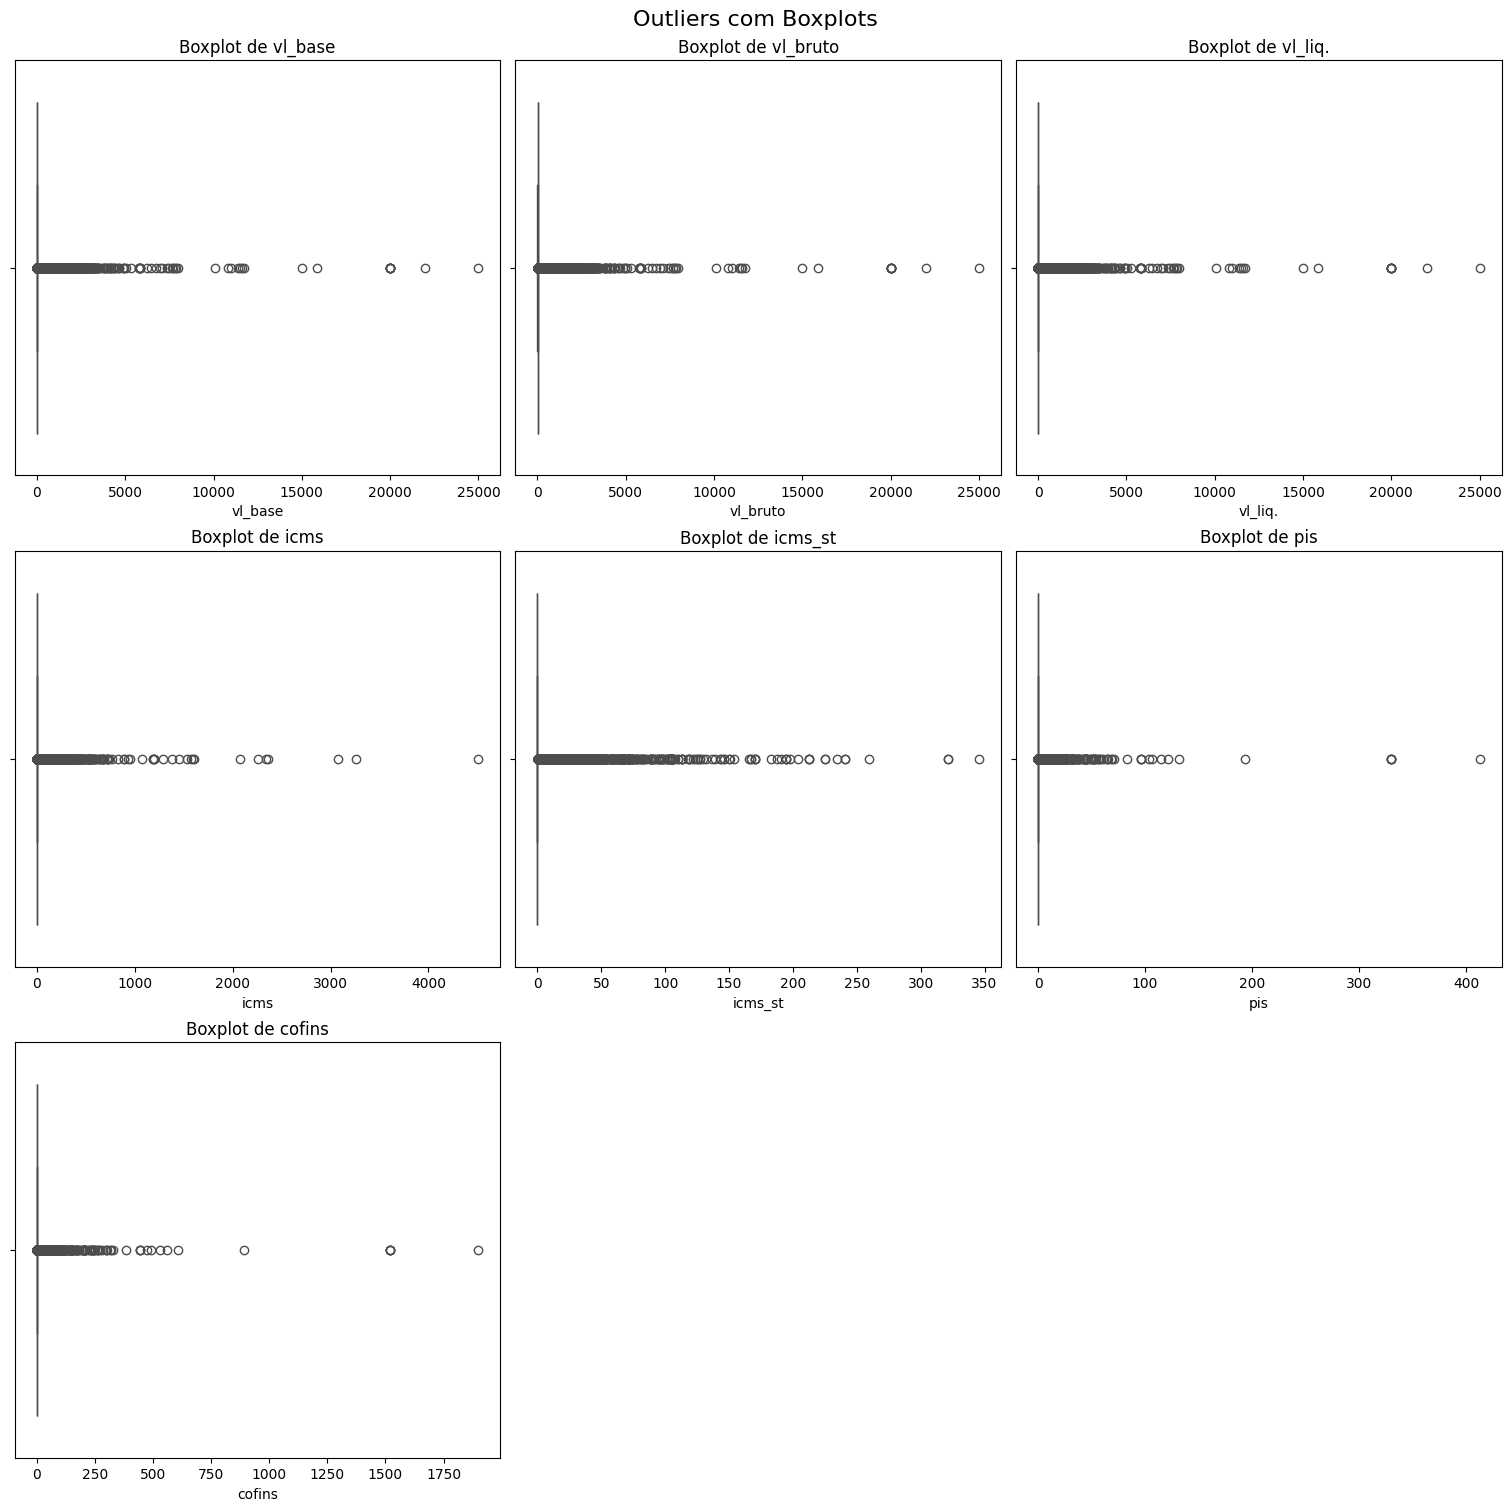

In [ ]:
eda_processor.detectar_outliers()

- Os casos de outliers mapeados usando a coluna: `v_liq`, por exemplo, identificam movimentações de entrada ou saída que não representam as operações normais no estoque da companhia. Por exemplo, a aquisição de um equipamento ou a venda de um item do inventário da loja. O que queremos analisar são as entradas e saídas dos produtos que compõem a operação do supermercado. Exemplo:

In [ ]:
df_corrigido[9865:9866]

,documento,data,codigo,produto,ncm,cfop,vl_base,vl_bruto,vl_liq.,cst_icms,...,fcp,iss,ipi,icms_st,fcp_st,cst_pis_cofins,pis,cofins,tipo_operacao,vl_liq_outlier
9865,2798/55,2024-04-29,344276,SACOLA MIXADA,39232190,1556,25000.0,25000.0,25000.0,40,...,0,0,0,0.0,0,50,412.5,1900.0,Compra dentro do estado,True


- > Este caso trata de uma aquisição de sacolas plásticas para a operação do supermercado. Para efeitos de impacto na análise fiscal, deixarei esses dados outliers, pois, mesmo sendo outliers, toda movimentação afeta o cálculo final dos impostos.

### Verificar valores nulos

In [ ]:
eda_processor.verificar_valores_invalidos()


Analisando valores nulos/NaN e outros valores inválidos...


,Valores Inválidos,Percentual (%)
documento,0,0.0
data,0,0.0
codigo,0,0.0
produto,0,0.0
ncm,0,0.0
cfop,0,0.0
vl_base,0,0.0
vl_bruto,0,0.0
vl_liq.,0,0.0
cst_icms,0,0.0


> A principal fonte de dados é o ERP do supermercado, que já possui um padrão de tratamento para valores nulos, NaN e valores inválidos (como strings vazias, por exemplo). Por isso, dificilmente teremos valores vazios aqui.

### Aplicação do describe nas colunas - Resumo estatístico sobre os dados presentes

In [ ]:
eda_processor.describe_colunas()


Resumo estatístico - Colunas Numéricas:


,data,vl_base,vl_bruto,vl_liq.,icms,icms_st,pis,cofins
count,600201,600201.000000,600201.000000,600201.000000,600201.000000,600201.000000,600201.000000,600201.000000
mean,2024-05-19 10:29:44.318253568,13.607201,13.738850,13.691464,1.920020,0.122457,0.112864,0.519898
min,2024-02-01 00:00:00,0.160000,0.160000,0.160000,0.000000,0.000000,0.000000,0.000000
25%,2024-03-27 00:00:00,2.500000,2.500000,2.500000,0.000000,0.000000,0.000000,0.000000
50%,2024-05-21 00:00:00,4.990000,4.990000,4.990000,0.510000,0.000000,0.030000,0.140000
75%,2024-07-11 00:00:00,8.800000,8.800000,8.800000,1.350000,0.000000,0.080000,0.380000
max,2024-08-31 00:00:00,25000.000000,25000.000000,25000.000000,4510.000000,345.630000,412.500000,1900.000000
std,NaN,118.421621,118.827063,118.698657,15.686448,2.430287,1.318395,6.072584



Resumo estatístico - Colunas Categóricas:


,documento,codigo,produto,ncm,cfop,cst_icms,fcp,iss,ipi,fcp_st,cst_pis_cofins,tipo_operacao
count,600201,600201,600201,600201,600201,600201,600201,600201,600201,600201,600201,600201
unique,127788,11437,11364,542,12,9,2,1,464,1,10,3
top,00579423/65,37312,ACUCAR CRISTAL RIACHO DO MEL 30X1KG-,19053100,5102,00,0,0,0,0,01,Venda dentro do estado
freq,219,7034,7034,53499,377547,389170,600200,600201,598801,600201,347960,574978


> Análise | Variáveis númericas:

- count: 600.201 registros em todas as três colunas, o que significa que não há valores ausentes, como já demonstrado.
- mean: a média é por volta de 13, o que indica que as operações (principalmente saídas) são, em geral, valores baixos;
    - Isso pode indicar que o ticket médio da basket dos clientes é baixo.
- std: a diferença entre o min e max é bem alta, o que sugere que há uma ampla faixa de variação nos valores das operações.
    - O alto desvio padrão (e.g. 118) fortalece essa hipótese. As colunas têm valores muito altos em relação à mediana (Q2), indicando uma assimetria nos dados, possivelmente devido à presença de poucas operações muito grandes.
    - Isso implica que nos próximas etapas o processo para tratar outliers deverá ser bem afinado para evitar erros nas análises de preço.

> Análise | Variáveis categóricas:

- Algumas categorias de produtos e operações, como o açúcar e as vendas internas, dominam o dataset.
    - Isso já é esperado, dado que as operações de venda são mais pulverizadas de acordo com a frequência de clientes e as operações de compra possuem uma menor frequência dado que as compras ocorrem por lote.
        - Por isso, para análise de preços, será necessário de um relatório com a movimentação de estoque, por documento, para ser possível entender por exemplo:
            - A que preço ocorre maior aceleração nas vendas de cada produto?
            - Qual o estoque mínimo para um determinado período por produto?
            - Dado o preço ideal, quais produtos precisamos promocionar para acelerar a movimentação de estoque?

### Distribuição dados númericos

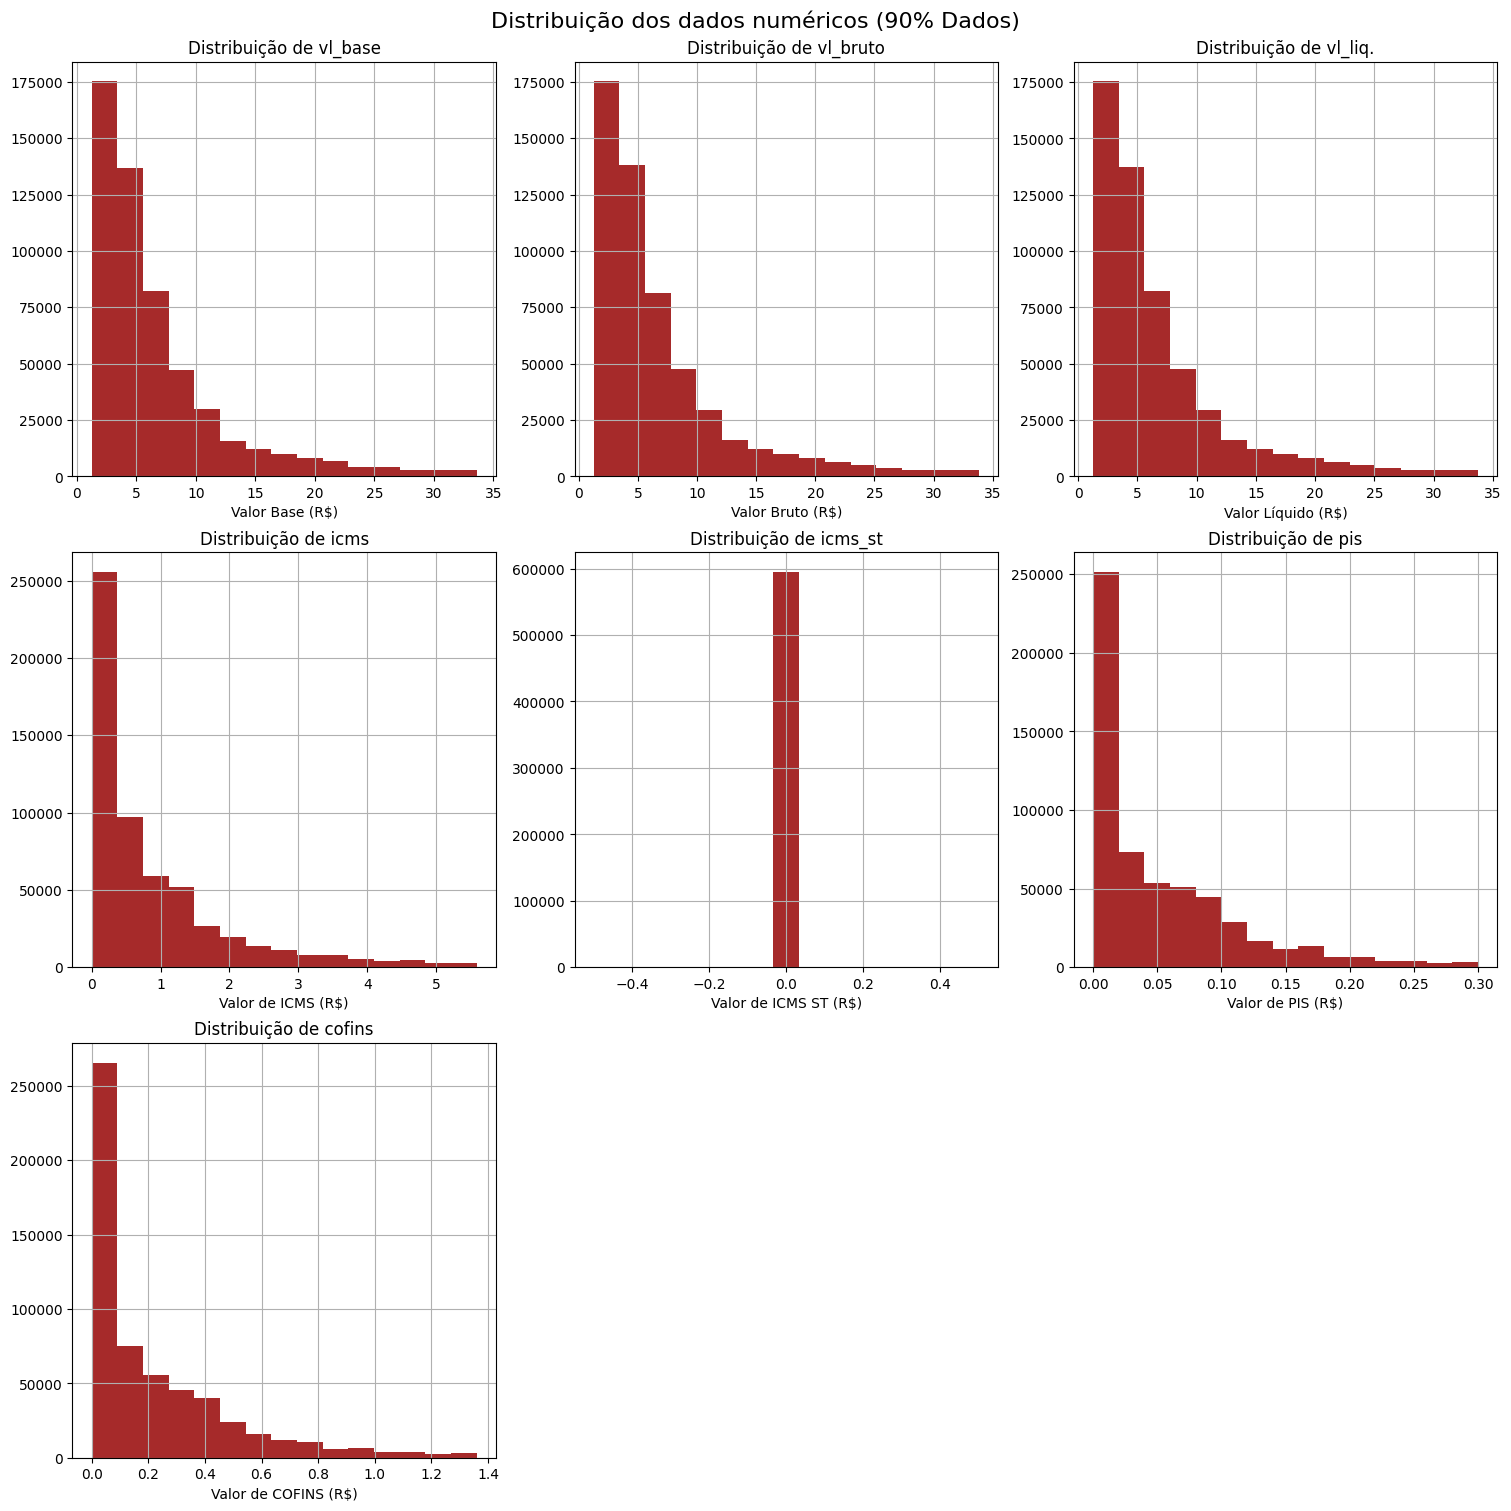

In [ ]:
legendas = {'vl_base': 'Valor Base (R$)', 'vl_bruto': 'Valor Bruto (R$)', 'vl_liq.': 'Valor Líquido (R$)', 'icms': 'Valor de ICMS (R$)', 'icms_st': 'Valor de ICMS ST (R$)', 'pis': 'Valor de PIS (R$)', 'cofins': 'Valor de COFINS (R$)'}
eda_processor.distribuir_dados_numericos(legendas=legendas)

> Análises:

- Como visto na análise de describe das colunas, aqui também é possível visualizar que os valores das operações possuem uma distribuição assimétrica com uma forte concentração de valores baixos, com a maioria dos dados entre 0 e 10. Isso sugere um ticket médio e uma maior frequência nas operações (principalmente de venda).

- No caso do gráfico de ICMS ST, é possível deduzir que grande parte das operações não sofrem com esse imposto, sugerindo que o Supermercado realiza operações concentradas dentro do estado.

### Análise de colunas categóricas

Coluna 'iss' possui um único valor, gráfico não será exibido.
Coluna 'fcp_st' possui um único valor, gráfico não será exibido.


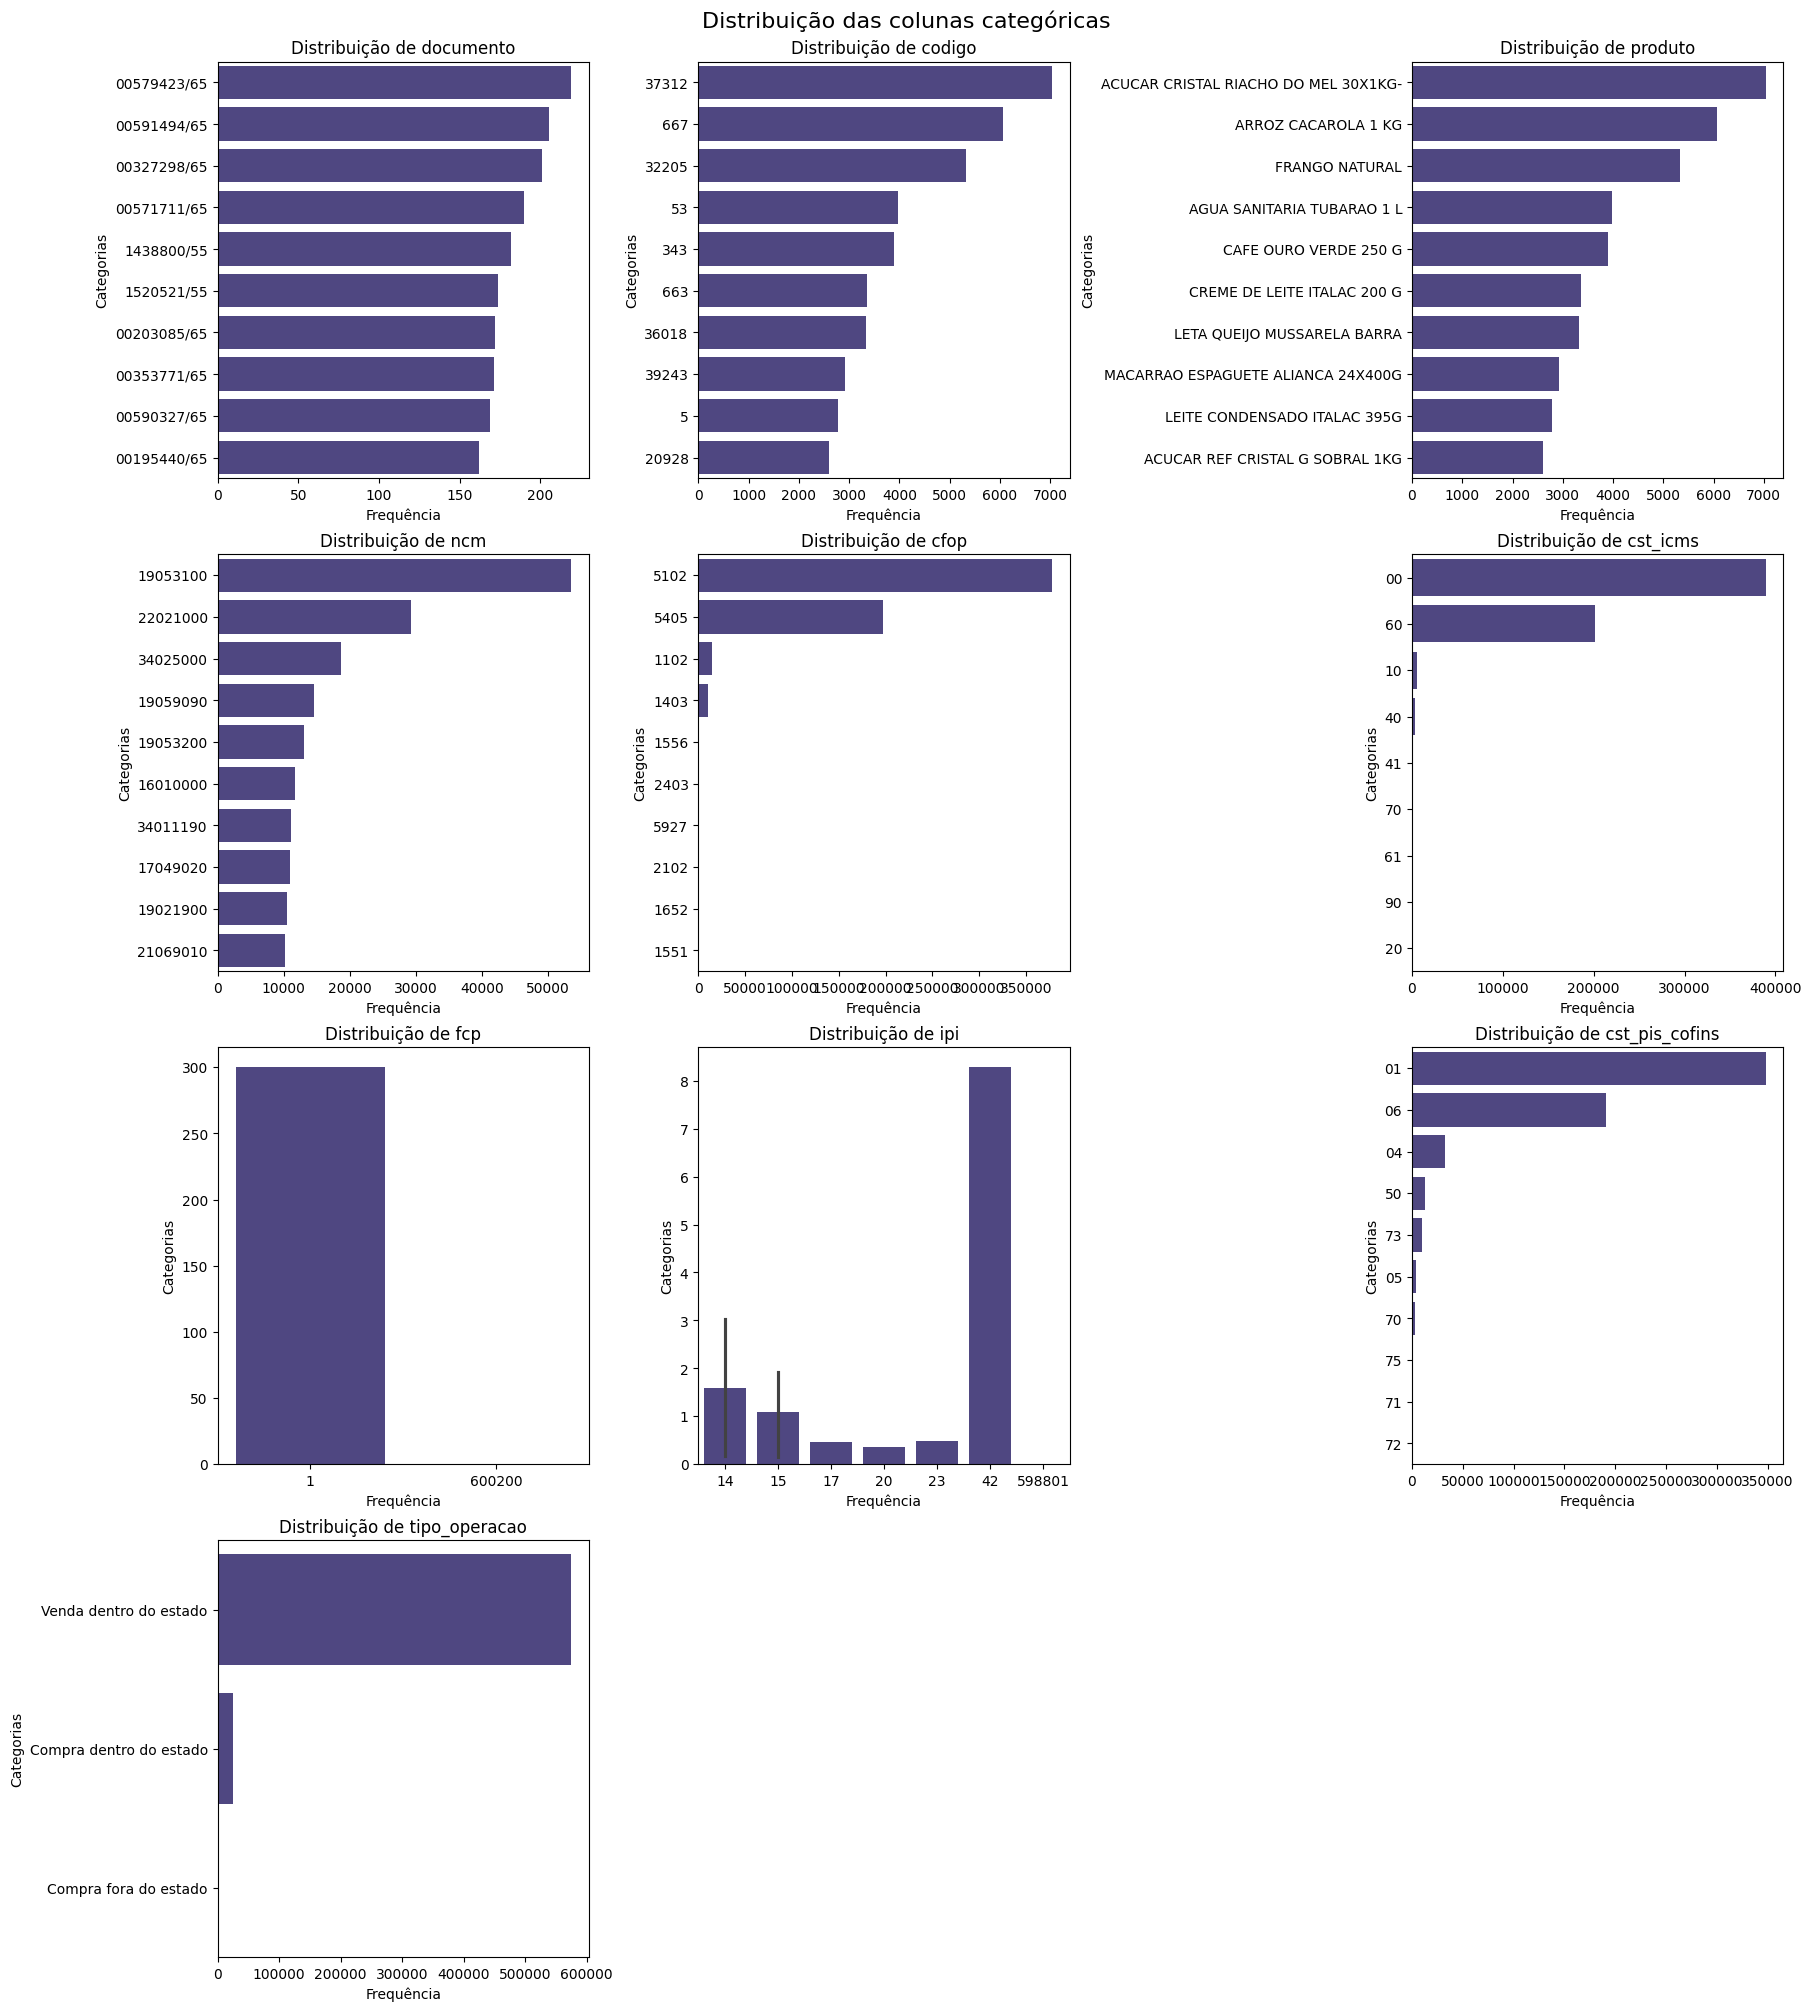

In [ ]:
categorias_por_coluna = {
    'documento': 10,
    'codigo': 10,
    'produto': 10,
    'ncm': 10
}

eda_processor.contar_valores_categoricos(categorias_por_coluna=categorias_por_coluna)

> Análises:

- O gráfico dos produtos mostra que o Açúcar Cristal Riacho Do Mel 30x1kg é o produto mais vendido, seguido por itens básicos como Arroz e Frango Natural. Isso reflete um comportamento comum em supermercados, onde produtos de necessidade básica dominam as vendas.

    - A maioria dos produtos pertence ao NCM 19053100, que representa: `Bolachas e biscoitos, adicionados de edulcorantes`, alimentos básicos, sendo esses os mais vendidos. Isso indica que a maioria dos produtos transacionados pertence a categorias essenciais ou amplamente consumidas.

- A venda dentro do estado é de longe a operação mais comum, enquanto operações de compra dentro e fora do estado são muito menos frequentes. Isso sugere que o supermercado realiza mais vendas do que compras e que a maioria das vendas é destinada ao estado onde a empresa opera.

- A distribuição de documentos mostra que alguns documentos aparecem com maior frequência, indicando possivelmente grandes transações. Abaixo vamos visualizar a média do count da coluna documents para verificar qual o tamanho médio em SKUs de cada documento.

In [ ]:
df_corrigido['documento'].value_counts().describe()

,count
count,127788.000000
mean,4.696849
std,8.777666
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,219.000000


- Ou seja, 75% dos documentos (compra e venda) possuem até 4 SKUs (códigos internos, produtos). Comprovando a hipótese de basket pequena por documento.

## Análise apuração mensal ICMS

* Cálculo mensal da apuração do ICMS.

* Objetivo: Definir uma meta de notas fiscais de entrada (compras) que mantenham o saldo de apuração de ICMS o mais próximo possível do breakeven.
    * De maneira geral, a apuração é a diferença entre Entradas(ICMS) e Saídas(ICMS) ((CFOP com início 1, 2, ou 3) - (CFOP com início 5, 6 ou 7)).
* Estratégia: Analisar o saldo atual de ICMS (entradas vs. saídas) e calcular qual o valor ideal de ICMS de entrada necessário para atingir um saldo neutro (ICMS Saídas - ICMS Entradas = 0).
* Aplicação: Na prática, em produção, será consumido um relatório diário no ERP do Supermercado e isso alimentará o alcance da meta, com base nas saídas e entradas diárias.

In [ ]:
class Impostoapuracao:
    def __init__(self, df):
        self.df = df

    def calcular_icms_mensal(self):

        self.df['mes_ano'] = self.df['data'].dt.to_period('M')

        self.df['tipo_operacao'] = self.df['cfop'].astype(str).str[0]
        entradas = self.df[self.df['tipo_operacao'].isin(['1', '2', '3'])].groupby('mes_ano')['icms'].sum()
        saidas = self.df[self.df['tipo_operacao'].isin(['5', '6', '7'])].groupby('mes_ano')['icms'].sum()
        saidas_nfe = self.df[self.df['tipo_operacao'].isin(['5', '6', '7'])].groupby('mes_ano')['vl_liq.'].sum()
        entradas_nfe = self.df[self.df['tipo_operacao'].isin(['1', '2', '3'])].groupby('mes_ano')['vl_liq.'].sum()

        proporcao_entrada = round(entradas / entradas_nfe.replace(0, float('nan')), 4).fillna(0)
        proporcao_saida = round(saidas / saidas_nfe.replace(0, float('nan')), 4).fillna(0)

        apuracao_icms = pd.DataFrame({
            'entradas_icms': entradas,
            'entradas_nfe': entradas_nfe,
            'proporcao_entrada': proporcao_entrada,
            'saidas_icms': saidas,
            'saidas_nfe': saidas_nfe,
            'proporcao_saida': proporcao_saida
        })

        apuracao_icms.fillna(0, inplace=True)
        apuracao_icms['apuracao_icms'] = apuracao_icms['entradas_icms'] - apuracao_icms['saidas_icms']
        apuracao_icms.reset_index(drop=False, inplace=True)

        apuracao_icms['meta'] = apuracao_icms.apply(
            lambda row: 0 if row['apuracao_icms'] > 0 or row['proporcao_entrada'] == 0 else round(abs(row['apuracao_icms']) / row['proporcao_entrada'], 2),
            axis=1
        )

        return apuracao_icms

    def produtos_mais_icms(self, mes=None):
        self.df['mes_ano'] = self.df['data'].dt.to_period('M')

        if mes:
            df_filtrado = self.df[self.df['mes_ano'] == mes]
        else:
            df_filtrado = self.df

        entradas = df_filtrado[df_filtrado['tipo_operacao'].isin(['1', '2', '3'])]
        saidas = df_filtrado[df_filtrado['tipo_operacao'].isin(['5', '6', '7'])]

        icms_produtos_entrada = entradas.groupby('produto')['icms'].sum().sort_values(ascending=False).head(10)
        icms_produtos_saida = saidas.groupby('produto')['icms'].sum().sort_values(ascending=False).head(10)

        fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)

        sns.barplot(x=icms_produtos_entrada.values, y=icms_produtos_entrada.index, ax=axes[0], palette="Blues_d")
        axes[0].set_title('Top 10 produtos - ICMS de entrada')
        axes[0].set_xlabel('Total de ICMS')
        axes[0].set_ylabel('Produto')

        for i, valor in enumerate(icms_produtos_entrada.values):
            # Verificar se o valor do rótulo ultrapassa o tamanho da barra
            if valor > max(icms_produtos_entrada.values) * 0.95:
                # Se o valor for muito grande, coloca o rótulo dentro da barra
                axes[0].annotate(f'{valor:.2f}', xy=(valor, i), va='center', ha='right', fontsize=10, color='white', xytext=(-5, 0), textcoords='offset points')
            else:
                # Coloca o rótulo fora da barra
                axes[0].annotate(f'{valor:.2f}', xy=(valor, i), va='center', ha='left', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

        sns.barplot(x=icms_produtos_saida.values, y=icms_produtos_saida.index, ax=axes[1], palette="Reds_d")
        axes[1].set_title('Top 10 produtos - ICMS de saída')
        axes[1].set_xlabel('Total de ICMS')
        axes[1].set_ylabel('Produto')

        for i, valor in enumerate(icms_produtos_saida.values):
            # Verificar se o valor do rótulo ultrapassa o tamanho da barra
            if valor > max(icms_produtos_saida.values) * 0.95:
                # Se o valor for muito grande, coloca o rótulo dentro da barra
                axes[1].annotate(f'{valor:.2f}', xy=(valor, i), va='center', ha='right', fontsize=10, color='white', xytext=(-5, 0), textcoords='offset points')
            else:
                # Coloca o rótulo fora da barra
                axes[1].annotate(f'{valor:.2f}', xy=(valor, i), va='center', ha='left', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

        plt.suptitle(f'Top 10 produtos com maior ICMS ({mes})', fontsize=16)
        plt.show()

impostos_apuracao = Impostoapuracao(df_corrigido)

In [ ]:
impostos_apuracao.calcular_icms_mensal()

,mes_ano,entradas_icms,entradas_nfe,proporcao_entrada,saidas_icms,saidas_nfe,proporcao_saida,apuracao_icms,meta
0,2024-02,72731.81,597731.16,0.1217,69028.13,520457.50,0.1326,3703.68,0.00
1,2024-03,71300.70,512956.85,0.1390,81519.30,591705.83,0.1378,-10218.60,73515.11
2,2024-04,77286.02,566458.32,0.1364,83914.46,561847.22,0.1494,-6628.44,48595.60
3,2024-05,82133.23,602183.27,0.1364,94105.71,633789.76,0.1485,-11972.48,87774.78
4,2024-06,81933.64,547177.61,0.1497,89100.74,609879.45,0.1461,-7167.10,47876.42
5,2024-07,74686.08,585685.55,0.1275,91331.21,626754.36,0.1457,-16645.13,130550.04
6,2024-08,92083.16,637061.50,0.1445,91243.54,623942.24,0.1462,839.62,0.00


> Sumário:

- Esta tabela vai ajudar, ao longo do mês, a direcionar o time de compras, sendo possível intensificar as compras em momentos em que o GAP para a meta estiver muito alto.


<ipython-input-20-8b4da0bf01c0>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=icms_produtos_entrada.values, y=icms_produtos_entrada.index, ax=axes[0], palette="Blues_d")
<ipython-input-20-8b4da0bf01c0>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=icms_produtos_saida.values, y=icms_produtos_saida.index, ax=axes[1], palette="Reds_d")


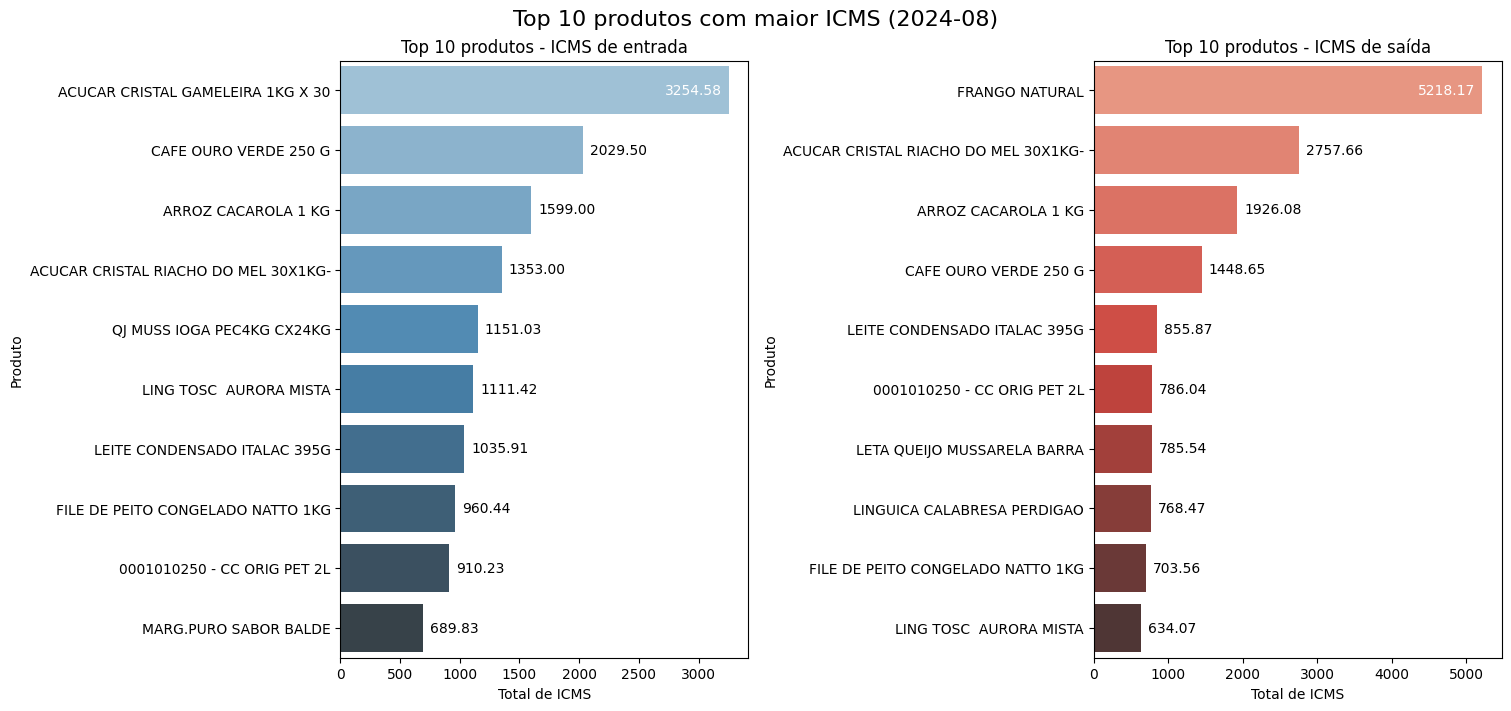

In [ ]:
impostos_apuracao.produtos_mais_icms(mes='2024-08')

> Sumário:

- Com essa visualização, é possível identificar os produtos que geram maior impacto na balança entre créditos e débitos do ICMS.
    - Do lado esquerdo, estão os produtos que geram mais crédito.
    - Do lado direito, estão os produtos que geram mais débito.

- Dessa forma, é possível traçar um plano para a compra dos produtos que historicamente geram mais débitos, visando garantir:
    1. Equilíbrio fiscal;
    2. Efetividade na gestão de compras.

## Considerações finais

> Next steps do projeto:

- Construir um pipeline para processar o relatório de movimentações, fundamental para a análise de preços.
    - Após isso, será importante filtrar dados outliers do conjunto, principalmente produtos que não são "constantemente" movimentados.
- Aprofundar a análise para entendimento de padrões a nível de produto.
